# Setup

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%reload_ext autoreload

In [2]:
import re
import os
import wandb
import string
import numpy as np
import unicodedata
import pandas as pd
from pathlib import Path
from datasets import load_dataset
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import pandas as pd

import sys
sys.path.append("../../src")

import util.preprocessing_util as util

In [3]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/paul.schmitt/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
data = load_dataset("Eladio/emrqa-msquad")

In [5]:
train_data = data["train"].to_pandas()
test_data = data["validation"].to_pandas()

# Inital Exploration

In [6]:
train_data.head()

,context,question,answers
0,The patient was admitted on 5/5/2006 with a hi...,What is her current dose of lasix ( furosemide ),"{'answer_end': [2598], 'answer_start': [2564],..."
1,This 57-year-old female with a distant history...,Is the patient currently or have they ever tak...,"{'answer_end': [541], 'answer_start': [532], '..."
2,An 81-year-old woman with Atrial Fibrillation ...,Has a patient had morphine,"{'answer_end': [1342], 'answer_start': [1319],..."
3,A 59 year-old woman with metastatic breast can...,Why was tessalon perles ( benzonatate ) origin...,"{'answer_end': [1007], 'answer_start': [988], ..."
4,Ms. Elter is an 83-year-old Spanish-speaking f...,Is there history of use of allopurinol,"{'answer_end': [539], 'answer_start': [475], '..."


In [7]:
sample = train_data.iloc[0]

In [8]:
print(f"Q: {sample.question}")
print(f"A: {sample.answers}")

Q: What is her current dose of lasix ( furosemide )
A: {'answer_end': array([2598]), 'answer_start': array([2564]), 'text': array(['LASIX (FUROSEMIDE) 20 MG PO DAILY,'], dtype=object)}


In [9]:
print("---------- Train-Set ----------")
print(len(train_data))
print("---------- Test-Set ----------")
print(len(test_data))

---------- Train-Set ----------
130956
---------- Test-Set ----------
32739


In [10]:
selected = ["context", "question"]

In [11]:
dropped = train_data[selected].drop_duplicates()

In [12]:
dropped

,context,question
0,The patient was admitted on 5/5/2006 with a hi...,What is her current dose of lasix ( furosemide )
1,This 57-year-old female with a distant history...,Is the patient currently or have they ever tak...
2,An 81-year-old woman with Atrial Fibrillation ...,Has a patient had morphine
3,A 59 year-old woman with metastatic breast can...,Why was tessalon perles ( benzonatate ) origin...
4,Ms. Elter is an 83-year-old Spanish-speaking f...,Is there history of use of allopurinol
...,...,...
130951,This is a 48-year-old female who was admitted ...,What types of medications have been tried for ...
130952,A 58 year old female smoker with a history of ...,Is there a mention of of zetia usage/prescript...
130953,The patient was admitted on 5/5/2006 with a hi...,What medications has patient been on for const...
130954,Mr. Kanaan is a 68-year-old gentleman with sta...,Is there history of use of prilosec


In [13]:
dropped.groupby("context").count().sort_values("question", ascending=True)

,question
context,
"Ms. Kolppa was a 58-year-old woman with a history of non-ischemic cardiomyopathy and ejection fraction of 15% who was initially admitted to the Faharb Medical Center Of following a cardiac arrest. On arrival in the emergency department she was found to have recurrent ventricular tachycardia and was defibrillated, and required pressor medications, an intraaortic balloon pump, and ventilator support to maintain her blood pressure, as her condition affected multiple organ systems. Due to poor neurological status and poor prognosis, and in conjunction with the patient's previously expressed wishes, medical care was withdrawn on 6/14 after many discussions with family, and the intraaortic balloon pump was turned off. Pressure medications were held and the mechanical ventilator was stopped, and the patient passed away on 0/14/07 shortly after removal of mechanical support.",39
"A 26-year-old male with a history of hypertension, obesity, and sleep apnea who was in a nursing home until two days prior to admission presented with shortness of breath. He also reported palpitations, cough with sputum, and right leg pain. His vital signs were temperature 101.2, pulse 110, blood pressure 128/72, and oxygen saturation 95% on room air and 98% while ambulating. Examination revealed dry mucous membranes, decreased breath sounds at the right lower base without wheezing, tachycardia, regular rhythm, and non-tender abdomen with no edema in the right calf. Labs showed a WBC of 14, MCV of 70, HCT of 47, and BNP of 2. The EKG was sinus tachycardia with T wave inversion in III and unchanged from prior. CXR was normal. The diagnosis was likely viral upper respiratory infection and the patient was given IBUPROFEN 600-800 MG PO TID PRN Pain for pain control. A lower extremity ultrasound of the right leg was negative for deep venous thrombus. The patient was discharged on 3/26/05 at 2:00 PM with instructions to resume regular exercise and follow up with his primary care doctor on October 25th. He was also advised to elevate his leg and use IBUPROFEN 600-800 MG PO TID PRN Pain as needed for pain control.",54
"This 63-year-old female patient presented with a history of a failed right hip hemiarthroplasty from 1992 and was admitted for a conversion to a total hip replacement. She tolerated the procedure well and was transferred to the Orthopaedic Floor postoperatively for pain control and physical therapy. She progressed rapidly over the next several days and was ambulating with assistance and partial weightbearing with physical therapy. Her wound was clean, dry, and intact with minimal drainage. She was afebrile throughout her hospital course and required one unit of blood during her hospital course to maintain her blood count greater than 30. Her discharge medications were Percocet 1-2 tabs p.o. q. 4-6 p.r.n. and she was also discharged on Coumadin 3.5 mg p.o. q. day and should maintain Coumadin therapy for six weeks time. The patient should have a prothrombin time checked biweekly to maintain an INR between 14 and 17. She was seen back in the office in six weeks time for x-rays and follow-up.",79
"The patient is a 60 year old black female presenting with a chief complaint of dizziness and syncope. She was initially seen in 1989, and pacer insertion was performed after an episode of asystole on the monitor. In March 1994, she was seen by the pacer service and found to have a high failure rate necessitating a new pacer insertion. Today, she passed out while walking back to bed and denied any trauma, chest pain, shortness of breath or palpitations. On admission, physical exam was normal and laboratory data showed K 3.9, mag 2.1, Hematocrit 38.9. EKG showed normal sinus rhythm and left ventricular hypertrophy. The patient was admitted and the story was most consistent with an arrhythmia induced syncope. Right upper extremity venogram showed patent vessels and pacemaker insertion was performed without any complications on 4 of October. The 

Lets look at one note-excerpt + the questions related to it

In [14]:
context = "A 26-year-old male with a history of hypertension, obesity, and sleep apnea who was in a nursing home until two days prior to admission presented with shortness of breath. He also reported palpitations, cough with sputum, and right leg pain. His vital signs were temperature 101.2, pulse 110, blood pressure 128/72, and oxygen saturation 95% on room air and 98% while ambulating. Examination revealed dry mucous membranes, decreased breath sounds at the right lower base without wheezing, tachycardia, regular rhythm, and non-tender abdomen with no edema in the right calf. Labs showed a WBC of 14, MCV of 70, HCT of 47, and BNP of 2. The EKG was sinus tachycardia with T wave inversion in III and unchanged from prior. CXR was normal. The diagnosis was likely viral upper respiratory infection and the patient was given IBUPROFEN 600-800 MG PO TID PRN Pain for pain control. A lower extremity ultrasound of the right leg was negative for deep venous thrombus. The patient was discharged on 3/26/05 at 2:00 PM with instructions to resume regular exercise and follow up with his primary care doctor on October 25th. He was also advised to elevate his leg and use IBUPROFEN 600-800 MG PO TID PRN Pain as needed for pain control."

In [15]:
selected_rows = train_data[train_data["context"] == context]

In [16]:
context

'A 26-year-old male with a history of hypertension, obesity, and sleep apnea who was in a nursing home until two days prior to admission presented with shortness of breath. He also reported palpitations, cough with sputum, and right leg pain. His vital signs were temperature 101.2, pulse 110, blood pressure 128/72, and oxygen saturation 95% on room air and 98% while ambulating. Examination revealed dry mucous membranes, decreased breath sounds at the right lower base without wheezing, tachycardia, regular rhythm, and non-tender abdomen with no edema in the right calf. Labs showed a WBC of 14, MCV of 70, HCT of 47, and BNP of 2. The EKG was sinus tachycardia with T wave inversion in III and unchanged from prior. CXR was normal. The diagnosis was likely viral upper respiratory infection and the patient was given IBUPROFEN 600-800 MG PO TID PRN Pain for pain control. A lower extremity ultrasound of the right leg was negative for deep venous thrombus. The patient was discharged on 3/26/05 

In [17]:
print(f"Questions related to this excerpt: {len(selected_rows)}")

Questions related to this excerpt: 57


In [18]:
upper_bound = 5
for i, item in enumerate(selected_rows.iterrows()):
    print(f"Q: {item[1].question}")
    print(f"A: {item[1].answers}")
    print("------------------")
    if i > upper_bound:
        break

Q: Why was the patient prescribed ibuprofen
A: {'answer_end': array([875]), 'answer_start': array([821]), 'text': array(['IBUPROFEN 600-800 MG PO TID PRN Pain for pain control.'],
      dtype=object)}
------------------
Q: Has the patient had previous ibuprofen
A: {'answer_end': array([875]), 'answer_start': array([821]), 'text': array(['IBUPROFEN 600-800 MG PO TID PRN Pain for pain control.'],
      dtype=object)}
------------------
Q: Has the patient ever tried ibuprofen
A: {'answer_end': array([875]), 'answer_start': array([821]), 'text': array(['IBUPROFEN 600-800 MG PO TID PRN Pain for pain control.'],
      dtype=object)}
------------------
Q: What pain meds has vet tried in past
A: {'answer_end': array([875]), 'answer_start': array([821]), 'text': array(['IBUPROFEN 600-800 MG PO TID PRN Pain for pain control.'],
      dtype=object)}
------------------
Q: How often does the patient take ibuprofen
A: {'answer_end': array([875]), 'answer_start': array([821]), 'text': array(['IBUPROF

# Transformation

In [19]:
train_data = util.transform_dataset_emrqa(train_data)
test_data = util.transform_dataset_emrqa(test_data)

  0%|          | 0/130956 [00:00<?, ?it/s]

  0%|          | 0/32739 [00:00<?, ?it/s]

In [20]:
train_data.head()

,question,context,target_sentence,target_index,label
0,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,The patient was admitted on 5/5/2006 with a hi...,0,0
1,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,Medications on Admission included Amiodarone 1...,1,0
2,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,An override was added on 10/2/06 by Gerad E. D...,2,0
3,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,The patient was rehydrated with IVF and PO's w...,3,0
4,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,Pain was controlled with TYLENOL (ACETAMINOPHE...,4,0


In [21]:
row = train_data.iloc[0]

In [22]:
row.question

'What is her current dose of lasix ( furosemide )'

In [23]:
row.context

"The patient was admitted on 5/5/2006 with a history of mechanical fall, with the attending physician being Dr. Clemente Armand Bolstad, with a full code status and disposition of Rehabilitation. Medications on Admission included Amiodarone 100 QD, Colace 100 bid, lasix 40mg QD, Glyburide 5mg bid, Plaquenil 200mg bid, Isordil 20mg tid, Lisinopril 20mg QD, Coumadin 5mg 3dys/week, 2.5mg 4dys/week, Norvasc 10mg QD, Neurontin 300mg TID, with APAP prn. An override was added on 10/2/06 by Gerad E. Dancy, PA for POTENTIALLY SERIOUS INTERACTION: AMIODARONE HCL & WARFARIN with the reason for override being monitoring. The patient was rehydrated with IVF and PO's were encouraged, holding Glypizide while in house, Novolog sliding scale was started on 1/2, Low dose NPH 6 units BID was started on 1/2, bridged with lovenox and INR therapeutic 1/2 and restarted on home regimen of 5/2.5mg variable dose. Pain was controlled with TYLENOL (ACETAMINOPHEN) 650 MG PO Q4H PRN Pain, Headache. A CT pelvis show

In [24]:
int(row.target_index)

0

In [25]:
row.target_sentence

'The patient was admitted on 5/5/2006 with a history of mechanical fall, with the attending physician being Dr. Clemente Armand Bolstad, with a full code status and disposition of Rehabilitation.'

# Further Exploration

In [26]:
print(f"Number of samples: {len(train_data)}")

Number of samples: 2285795


## Class balance

In [27]:
label_counts = train_data['label'].value_counts(normalize=True).sort_index()

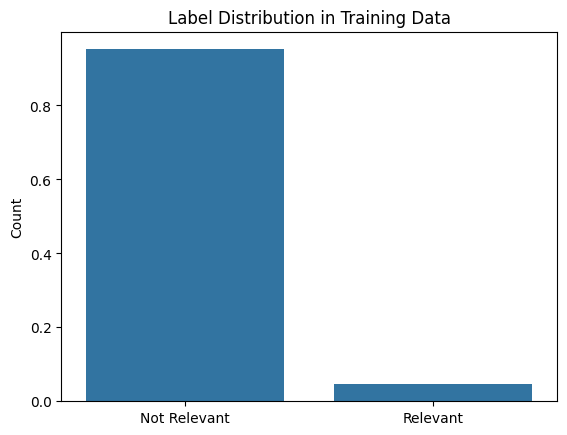

Label counts:
 label
0    0.952057
1    0.047943
Name: proportion, dtype: float64


In [28]:
label_names = ["Not Relevant", "Relevant"]

sns.barplot(x=label_names, y=label_counts.values)
plt.title("Label Distribution in Training Data")
plt.ylabel("Count")
plt.show()

print("Label counts:\n", label_counts)

Most of the data is label = 0 (irrelevant) → **classic class imbalance**

**For later (options):**
- Class weighting in loss functio
- Undersampling negatives during training

## Sentence Length Distribution

typical size of input sentences (in tokens/words)

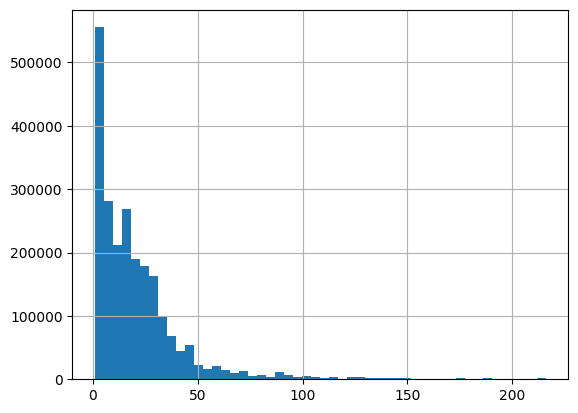

In [29]:
train_data['sent_len'] = train_data['target_sentence'].str.split().apply(len)
train_data['sent_len'].hist(bins=50)
train_data = train_data.drop('sent_len', axis=1).reset_index(drop=True)

## Relevant Sentences per Question

In [30]:
train_data.groupby('question')['label'].sum().describe()

count    50727.000000
mean         2.160349
std          4.283482
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        177.000000
Name: label, dtype: float64

Most questions are answered by just 1–2 sentences -> aligns well with **ArchEHR-QA**

## Duplicate Sentence Check

In [31]:
print(f"Percentage of duplicates: {int(train_data.duplicated().sum()) / len(data)}")

Percentage of duplicates: 32827.0


Not to many dupliactes but we still going to **remove them** since we are somehow prone to overfitting with the model on the PubMED dataset

In [32]:
train_data = train_data.drop_duplicates().reset_index(drop=True)
test_data = test_data.drop_duplicates().reset_index(drop=True)

In [33]:
print(f"Number of samples in train (final): {len(train_data)}")
print(f"Number of samples in test (final): {len(test_data)}")

Number of samples in train (final): 2220141
Number of samples in test (final): 570608


In [34]:
train_data.head()

,question,context,target_sentence,target_index,label
0,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,The patient was admitted on 5/5/2006 with a hi...,0,0
1,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,Medications on Admission included Amiodarone 1...,1,0
2,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,An override was added on 10/2/06 by Gerad E. D...,2,0
3,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,The patient was rehydrated with IVF and PO's w...,3,0
4,What is her current dose of lasix ( furosemide ),The patient was admitted on 5/5/2006 with a hi...,Pain was controlled with TYLENOL (ACETAMINOPHE...,4,0


# Preprocessing

In [35]:
train_data.dtypes

question           object
context            object
target_sentence    object
target_index        int64
label               int64
dtype: object

In [36]:
text_column_names = ("question", "target_sentence", "context")

In [37]:
train_data = util.clean_text_df(train_data, text_column_names)
test_data = util.clean_text_df(test_data, text_column_names)

Check for potential missing values

In [38]:
print("---- Train Set ----")
print(train_data.isnull().sum())
print("---- Test Set ----")
print(test_data.isnull().sum())

---- Train Set ----
question           0
context            0
target_sentence    0
target_index       0
label              0
dtype: int64
---- Test Set ----
question           0
context            0
target_sentence    0
target_index       0
label              0
dtype: int64


In [39]:
train_data.head()

,question,context,target_sentence,target_index,label
0,what is her current dose of lasix furosemide,the patient was admitted on 552006 with a hist...,the patient was admitted on 552006 with a hist...,0,0
1,what is her current dose of lasix furosemide,the patient was admitted on 552006 with a hist...,medications on admission included amiodarone 1...,1,0
2,what is her current dose of lasix furosemide,the patient was admitted on 552006 with a hist...,an override was added on 10206 by gerad e danc...,2,0
3,what is her current dose of lasix furosemide,the patient was admitted on 552006 with a hist...,the patient was rehydrated with ivf and pos we...,3,0
4,what is her current dose of lasix furosemide,the patient was admitted on 552006 with a hist...,pain was controlled with tylenol acetaminophen...,4,0


In [42]:
aggregated_train_data = util.aggregate_sentences_by_question_and_context(train_data)
aggregated_test_data = util.aggregate_sentences_by_question_and_context(test_data)

**Persist if necessary**

In [44]:
data_output_dir = Path("../../data/dev/processed/")
data_output_dir.mkdir(parents=True, exist_ok=True)

In [45]:
aggregated_train_data.to_csv(data_output_dir / "emrqa-msquad_train.csv", index=False)
aggregated_test_data.to_csv(data_output_dir / "emrqa-msquad_test.csv", index=False)